### Economy of negative climate impacts of drained peatland restoration

Samuli Launiainen & Anssi Ahtikoski Oct, 2025.

Pipeline to calculate GHG budgets and atmospheric radiative forcing of alternative drained peatland forest management chains and restoration scenarios. 

Steps:

1) Read Motti-outputs (metsikkötaulu) for a given site and management chain, compute NPP and fluxes to residue and wood product pools

2) Estimate pool C dynamics and compute CO2, CH4 and N2O fluxes between system components and the atmosphere

3) Calculate changes in atmospheric GHG stocks and resulting radiative forcings (RF's)

4) Save results to Excel-files, with sheets corresponding to scenarios

Todo: 

- correct OptiMotti RootsC & RootsF initial state
- add albedo RF (relative to open peatland)

To move on from Ambio-paper:

- For discussion point, add hypothetical 'water management' scenario, where forestry is conducted with reduced drainage and water table (WT)
- compute forestry CH4 and N2O soil emissions using Minkkinen et al. WT-dependent model  
- for added realism, use SpaFHy-Peat to infer location-specific Vol - WT -responses that can account for different ditch spacing, ditch dept and peat type - and realization of past 30 year weather. This is needed for HIKET - ask J-P Nousu!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# module main keeps track on C stocks and GHG fluxes between system components and the atmosphere
# calls functions from module radiative_forcing to compute RF's

from main import compute_stocks_fluxes, compute_RFs

# module motti_tools does massaging of Motti inputs
from motti_tools import massage_LukeMotti, massage_OptiMotti

#from main import wood_pools, soilCO2

# force iPython re-import modules at each call
%load_ext autoreload
%autoreload 2

EPS = 1e-6

folder = r'Data/ES'

### Run pipeline

In [ ]:
# simulations in 'folder'
sims = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
M = len(sims)
for k in range(0,M):
    s = sims[k]

    # -- coding for computing soil fluxes in forestry and restoration
    if any(stype in s for stype in ['Rhtkg', 'Mtkg']):
        ftype = 'FNR' # nutrient rich
        rtype = ['RME', 'ROL', 'RSM']
    else: 
        ftype = 'FNP' # nutrient poor
        rtype = ['ROL', 'ROM', 'RPM']
    
    # -- read Motti-results. Two versions: LukeMotti and OptiMotti. Uses functions from module motti_tools
    path = os.path.join(folder, s)
    if 'suositusten' in s:
        ffile = [f for f in os.listdir(path)
                  if os.path.isfile(os.path.join(path, f)) and 'suositusten' in f][0]
        
        ffile = os.path.join(path, ffile)
        data = massage_LukeMotti(ffile)
    
    else:
        ffile = os.path.join(path, 'Development_opt.csv')
        if 'CCF' in ffile:
            data = massage_OptiMotti(ffile, CCF=True)
        else:
            data = massage_OptiMotti(ffile, CCF=False)
    
    # --- simulate continued forestry scenarios

    # forest management continues
    f0 = compute_stocks_fluxes(data.copy(), ftype=ftype, fyear=2025)
    rf0 = compute_RFs(x=f0)
    
    ## water management scenario here! Will lead to smaller soil CO2 emissions
    #fw = compute_stocks_fluxes(... add flag to change Volume - WT relationship)
    #rfw = compute_RFs(x=fw)

    # --- simulate restoration scenarios
    f1 = compute_stocks_fluxes(data.copy(), ftype=rtype[0], fyear=2025) 
    rf1 = compute_RFs(x=f1)
    f2 = compute_stocks_fluxes(data.copy(), ftype=rtype[1], fyear=2025)
    rf2 = compute_RFs(x=f2)
    f3 = compute_stocks_fluxes(data.copy(), ftype=rtype[2], fyear=2025)
    rf3 = compute_RFs(x=f3)
    
    # --- save results to Excel file named based on Motti-chain used as input data
     
    outfile = os.path.join(folder)
    outfile = os.path.join(outfile, s + '.xlsx')

    
    with pd.ExcelWriter(outfile, engine='openpyxl') as writer:
        tmp = pd.concat([f0, rf0], axis=1)
        tmp.to_excel(writer, sheet_name=ftype, index=False)
        tmp = pd.concat([f1, rf1], axis=1)
        tmp.to_excel(writer, sheet_name='Rest_' + rtype[0], index=False)
        tmp = pd.concat([f2, rf2], axis=1)
        tmp.to_excel(writer, sheet_name='Rest_' + rtype[1], index=False)
        tmp = pd.concat([f3, rf3], axis=1)
        tmp.to_excel(writer, sheet_name='Rest_' + rtype[2], index=False)
        
        # -- save used Motti-data
        data.to_excel(writer, sheet_name=s.strip('.'), index=False)

# for c in ['C_tree', 'C_resid', 'C_WP_short', 'C_WP_long', 'C_soil', 'F_tree', 'F_resid', 'F_soil', 'F_WP_short', 'F_WP_long', 'F_CH4', 'F_N2O']:
#     plt.figure()
#     plt.plot(f0[c], 'r.-', label=ftype)
#     plt.plot(f1[c], 'g.-', label=rtype[0])
#     plt.plot(f2[c], 'b.-', label=rtype[1])
#     plt.plot(f3[c], 'k.-', label=rtype[2])   
#     plt.legend()
#     plt.title(c)

### How to implement reduced drainage?

Text(0.5, 0, 'Vol (m3ha-1)')

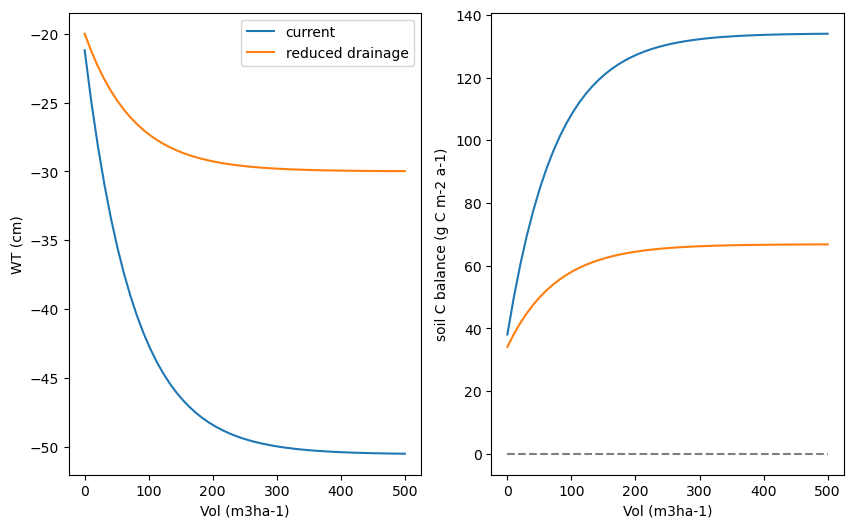

In [8]:
#from main import soilCO2

def soil_C_balance(wtd, ftype='FNR'):
    if ftype == 'FNR':
        f = -115.0  -12.0 * wtd
    elif ftype == 'FNP':
        f = -259.0 - 6.0 * wtd
    f = f * (12/44) # gCO2 to g C

    return f

# WT relations

x = np.linspace(0, 500, 50)

# current vol - WT relationship
a = -50.56; b = 29.356; c = 0.98698
wtd = a + b * np.power(c, x)
f = soil_C_balance(wtd, ftype='FNR')

# hypothetical with less intensive drainage
a = -30.0; b = 10.0; c = 0.98698
wtd1 = a + b * np.power(c, x)
f1 = soil_C_balance(wtd1, ftype='FNR')

fig, ax = plt.subplots(1,2, figsize=(10, 6))

ax[0].plot(x, wtd, '-', label='current')
ax[0].plot(x, wtd1, '-', label='reduced drainage')
ax[0].set_ylabel('WT (cm)')
ax[0].set_xlabel('Vol (m3ha-1)')
ax[0].legend()

ax[1].plot([0,max(x)], [0, 0], 'k--', alpha=0.5)
ax[1].plot(x, f, '-', label='current')
ax[1].plot(x, f1, '-', label='reduced drainage')
ax[1].set_ylabel('soil C balance (g C m-2 a-1)')
ax[1].set_xlabel('Vol (m3ha-1)')

